<a href="https://colab.research.google.com/github/gonzaq94/ddpm-mednist/blob/main/1_monai_ddpm_with_mednist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Models (DDPM) with MedNIST dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q matplotlib monai monailabel monai-generative
%matplotlib inline

First impor the necessary packages, and you can verify the installation by:

In [ ]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import monai
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

set_determinism(42)

monai.config.print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.0.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 9.4.0
Tensorboard version: 2.17.0
gdown version: 4.7.3
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.7.0
transformers version: 4.42.4
mlflow version: 2.15.1
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set up the MedNIST Dataset

In this tutorial, we will train our models on the MedNIST dataset available on MONAI (https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset).

In order to train faster, we will select just one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable. For the convenience, we use the `data` folder in the current path:

In [ ]:
root_dir = './'
data_dir = './data/'
os.makedirs(data_dir, exist_ok=True)

train_data = MedNISTDataset(root_dir=data_dir,
                            section="training",
                            download=True,
                            progress=False,
                            seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]

2024-08-17 15:47:58,790 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-08-17 15:47:58,791 - INFO - File exists: data/MedNIST.tar.gz, skipped downloading.
2024-08-17 15:47:58,802 - INFO - Non-empty folder exists in data/MedNIST, skipped extracting.


Here we use transforms to augment the training dataset:

- `LoadImaged` loads the hands images from files.
- `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
- `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
- `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"],
                                        a_min=0.0,
                                        a_max=255.0,
                                        b_min=0.0,
                                        b_max=1.0,
                                        clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, persistent_workers=True)

Loading dataset: 100%|██████████| 7999/7999 [00:18<00:00, 435.68it/s]


We can get the validation data the same way:

In [ ]:
val_data = MedNISTDataset(root_dir=data_dir,
                          section="validation",
                          download=True,
                          progress=False,
                          seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"],
                                        a_min=0.0,
                                        a_max=255.0,
                                        b_min=0.0,
                                        b_max=1.0,
                                        clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)

2024-08-17 15:49:02,242 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-08-17 15:49:02,254 - INFO - File exists: data/MedNIST.tar.gz, skipped downloading.
2024-08-17 15:49:02,261 - INFO - Non-empty folder exists in data/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 1005/1005 [00:02<00:00, 433.05it/s]


### Visualisation of the training images

Let see what the training images look like:

batch shape: torch.Size([16, 1, 64, 64])


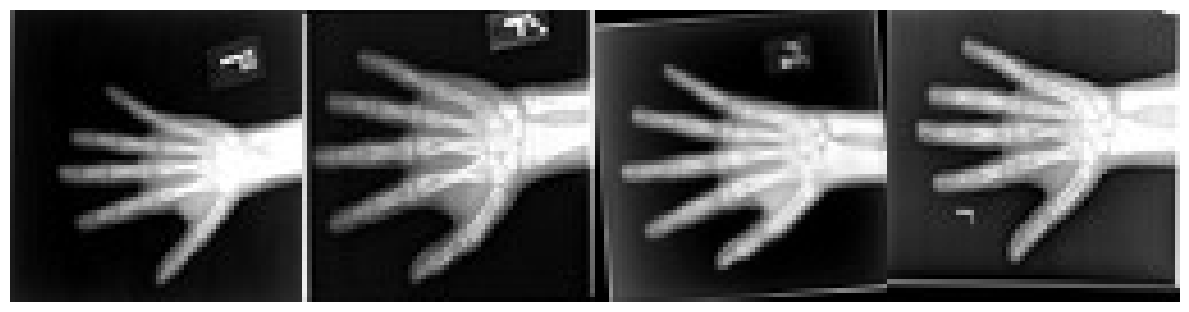

In [ ]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0],
     check_data["image"][1, 0],
     check_data["image"][2, 0],
     check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a *DDPM*, the *UNET*, the *noise scheduler*, and the *inferer* used for training and sampling.

We are using the original DDPM scheduler containing `1000` timesteps in its Markov chain, and a 2D UNET with attention mechanisms in the 2nd and 3rd levels, each with 1 attention head.


In [ ]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    schedule="linear_beta",
    beta_start=0.0005,
    beta_end=0.0195)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Model training

Here, we are training our model for 75 epochs (training time: ~50 minutes).

For tutorial, if you would like to skip the training and use a pre-trained model instead, set use_pretrained=True. This model was pretrained using the model in `pretrained/DDPM.pt`.

In [ ]:
use_pretrained = False

if use_pretrained:
    os.makedirs('./pretrained/', exist_ok=True)
    import urllib.request
    url = 'https://raw.githubusercontent.com/vios-s/ISBI-2024-DiMEDIA-MONAI-Tutorial/main/pretrained/DDPM.pt'
    print ("Download start!")
    filename, headers = urllib.request.urlretrieve(url, filename="./pretrained/DDPM.pt")
    print("Download Complete.")
    model.load_state_dict(torch.load('pretrained/DDPM.pt'))
    #model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0,
                    inferer.scheduler.num_train_timesteps,
                    (images.shape[0],),
                    device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(
                    inputs=images,
                    diffusion_model=model,
                    noise=noise,
                    timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")


In [ ]:
torch.save(model.state_dict(), f'drive/MyDrive/DDPM/models/DDPM_{n_epochs}_eps.pt')

## Plot the Learning Curve

In [ ]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8-white")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

## Plotting sampling process along DDPM's Markov chain

In [ ]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Last generated image

In [ ]:
plt.imshow(image.squeeze().cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.show()